# Проект "Аналитика в авиакомпании"

## Описание задачи от заказчика

Изучить базу данных  о самолетах и количестве рейсов для них в сентябре 2018 года, а также среднем количестве рейсов в городах за август 2018 года. Проанализировать спрос пассажиров на рейсы в города, где проходят крупнейшие фестивали.

## Определение целей исследования

- Найти: ТОП 10 городов по количеству рейсов
- Построить графики: модели самолетов и количество рейсов, города и количество рейсов, топ-10 городов и количество рейсов

## Подготовка данных

### Импорт библиотек

In [11]:
import pandas as pd 
from IPython.display import display
import matplotlib.pyplot as plt
import math
import __main__
from scipy import stats as st
import numpy as np


### Импорт функций

In [12]:
# Функция для подсчета количества корзин для гистограммы по правилу Герберта Стерджеса
def bins_num_sturges(column):  
    bins_num = abs(1 + int(math.log2(len(column))))
    if(bins_num) < 200:
        return bins_num
    else:
        return 200
    
# Функция для подсчета количества корзин для гистограммы по правилу Фридмана-Дьякониса     
def bins_num_fr_dk(column): 
    Q1 = column.quantile(0.25) #находим первый квартиль
    Q3 = column.quantile(0.75) #находим третий квартиль
    IQR = Q3 - Q1 #находим межквартильный размах
    bins_num = int(abs(2 * IQR * len(column)**(-1/3)))
    print(bins_num)
    if bins_num < 1:
        return 1
    elif bins_num < 200:
        return bins_num
    else:
        return 200
    
# Функция для отрисовки гистограммы с возможностью выбора размера фигуры и способа подсчета корзин 
def draw_hist(dataframe,column,way_bins,xsize=6,ysize = 4): 
    if (way_bins == 'S'):
        dataframe.hist(
                column,
                bins =  bins_num_sturges(dataframe[column]),
                figsize=(xsize,ysize)
                )          
    elif (way_bins == 'FD'):
        dataframe.hist(
                column,
                bins =  bins_num_fr_dk(dataframe[column]),
                figsize=(xsize,ysize)
              )    
    else:
        way_bins = pd.to_numeric(way_bins) #гистограмма с произвольным числом корзин
        dataframe.hist(
                column,
                bins =  way_bins,
                figsize=(xsize,ysize)
              )
    plt.show() 

# Функция для отрисовки boxplot
def draw_boxplot(dataframe,column):
    dataframe.boxplot(column)
    return plt.show()

# Находим границы "усов"
def find_moustache(column): 
    Q1,Q3 = column.quantile([.25,.75]) #находим первый и третий квартили
    IQR = Q3 - Q1 #находим межквартильный размах
    min_val = Q1 - (IQR * 1.5) 
    max_val = Q3 + (IQR * 1.5)
    
    if(min_val < column.min()):
        if(max_val > column.max()):
            return column.min(),column.max()
        else:
            return column.min(),max_val         
    elif(max_val > column.max()):
            return min_val,column.max()
    else:
        return min_val,max_val
           
# Функция для подсчет количества данных находящимися за пределами "усов" и нахождение процента от общих данных
def num_normalized_data_info(dataframe,column): 
    try:
        min_val,max_val = find_moustache(dataframe[column])
    except:
        return print('Не удалось найти усы в ',column,', проблема с типом данных')
    print('Количество данных из столбца ',column, ', которые считаем выбросами:'
      ,dataframe[((dataframe[column] > max_val) | (dataframe[column] < min_val)) & ~dataframe[column].isna()][column].count()
      ,', процент от общего числа: {:.1%}'
      .format(
          dataframe[(dataframe[column] > max_val) | (dataframe[column] < min_val)][column].count()/dataframe[column].count()
          )
    ) 

# Отбор данных без выбросов 
def num_normalized_data(dataframe,column,with_nan = True): 
    try:
        min_val,max_val = find_moustache(dataframe[column])
    except:
        return print('Не удалось найти усы в ',column,', проблема с типом данных')
    if (with_nan):
        return dataframe[((dataframe[column] <= max_val) & (dataframe[column] >= min_val)) | dataframe[column].isna()] 
    else:
        return dataframe[(dataframe[column] <= max_val) & (dataframe[column] >= min_val)]

# Проверяем, что в финальной выборке нет выбросов
def num_normalized_data_check(dataframe,column,dataframe2): 
    try:
        min_val,max_val = find_moustache(dataframe2[column])# квантили и "усы" берем из изначальных данных
    except:
        return print('Не удалось найти усы в ',column,', проблема с типом данных')
    
    return print('Количество выбросов в столбце ',column, ' в итоговой выборке:',dataframe[((dataframe[column] > max_val) | (dataframe[column] < min_val)) & (~dataframe[column].isna())][column].count());
    
    
# функция для отрисовки диаграммы рассеивания
def draw_scatter(dataframe,xcolumn,ycolumn,xsize = 8, ysize = 6,gridsize = 12):
    dataframe.plot(
    x=xcolumn, 
    y=ycolumn, 
    kind='scatter', 
    figsize=(xsize, ysize), 
    alpha = 0.1, 
    )
    
    return plt.show()

# Поиск дублей с учетом регистра
def reg_duplicates_alert(dataframe,column):
    if(len(dataframe[column].unique()) == len(dataframe[column])):
        return print('Дублей в столбце',column, 'нет.')
    else:
        return print('Дубли,в столбце',column, 'есть.')

### Импорт данных

In [13]:
dataset1 = pd.read_csv('/datasets/query_1.csv')
dataset2 = pd.read_csv('/datasets/query_3.csv').sort_values(by='average_flights',ascending = False)

display(dataset1)
print(dataset1.columns)
display(dataset2)
print(dataset2.columns)

,model,flights_amount
0,Airbus A319-100,607
1,Airbus A321-200,960
2,Boeing 737-300,630
3,Boeing 767-300,600
4,Boeing 777-300,300
5,Bombardier CRJ-200,4446
6,Cessna 208 Caravan,4557
7,Sukhoi SuperJet-100,4185


Index(['model', 'flights_amount'], dtype='object')


,city,average_flights
43,Москва,129.774194
70,Санкт-Петербург,31.161290
54,Новосибирск,17.322581
33,Красноярск,11.580645
20,Екатеринбург,11.322581
...,...,...
22,Ижевск,1.000000
65,Петропавловск-Камчатский,1.000000
31,Комсомольск-на-Амуре,1.000000
58,Нягань,1.000000


Index(['city', 'average_flights'], dtype='object')


В таблице dataset1 данные в порядке, пропусков, ошибок, дублей нет. Тип данных изменим позже на целочисленный. Однако, dataset2 необходимо изучить подробнее.

### Обработка пропусков

In [14]:
for each in dataset2.columns.tolist():
    print('Количество NaN в столбце',each,': ', dataset2[each].isna().sum())


Количество NaN в столбце city :  0
Количество NaN в столбце average_flights :  0


Отлично, пропусков в таблице нет.

### Поиск и обработка дублей и ошибок в данных

In [15]:
print('Дублей в таблице: ',dataset2['city'].str.lower().duplicated().sum())# Поиск дублей, не учитывая регистр

exceptions = []# список для записи столбцов, в которых не удалось проверить на отрицательные значения

for column in dataset2.columns.values.tolist():  
    try:
        data = dataset2[dataset2[column] < 0]
        if len(data) != 0:
            print('Отрицательные значения в таблице: \r\n',data)
    except:
        exceptions.append(column)
            
print('Не удалось найти отрицательные значения в столбцах: ',exceptions)

Дублей в таблице:  0
Не удалось найти отрицательные значения в столбцах:  ['city']


Дублей и ошибок в таблице не найдено. Теперь перейдем к изменению типов данных.  

### Преобразование типов данных

Необходимо изменить тип данных в столбцах **"flights_amount"** и **"average_flights"** на int и float соответственно. 

In [16]:
dataset1['flights_amount'] = dataset1['flights_amount'].astype('Int64')
dataset2['average_flights'] = dataset2['average_flights'].astype(float)
display(dataset1.info())
display(dataset2.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 2 columns):
model             8 non-null object
flights_amount    8 non-null Int64
dtypes: Int64(1), object(1)
memory usage: 264.0+ bytes


None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101 entries, 43 to 49
Data columns (total 2 columns):
city               101 non-null object
average_flights    101 non-null float64
dtypes: float64(1), object(1)
memory usage: 2.4+ KB


None

### Вывод

Данные в порядке, пропусков, дублей и ошибок нет. Типы данных приведены к корректным. Теперь можно переходить к анализу данных.

## Анализ данных

Найдем ТОП-10 городов по среднему количеству рейсов в августе 2018 года.

In [17]:
dataset3 = dataset2.sort_values(by='average_flights',ascending = False).reset_index(drop=True).head(10)
display(dataset3)

,city,average_flights
0,Москва,129.774194
1,Санкт-Петербург,31.161290
2,Новосибирск,17.322581
3,Красноярск,11.580645
4,Екатеринбург,11.322581
5,Ростов-на-Дону,10.193548
6,Пермь,10.129032
7,Брянск,10.000000
8,Сочи,9.612903
9,Ульяновск,9.580645


Ожидаемо первую тройку составляют самые крупные города: Москва, Санкт-Петербург и Новосибирск. Замыкает ТОП-10 Ульяновск, однако 4-10 места из топа не сильно отличаются между собой. Точные значения представлены в таблице.

Построим графики: модели самолетов и количество рейсов, города и количество рейсов, топ-10 городов и количество рейсов

### График "модель самолета/количество рейсов"

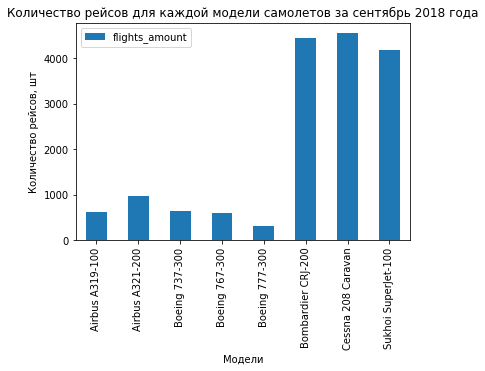

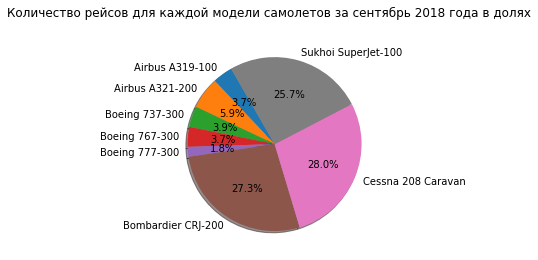

In [53]:
dataset1.plot('model','flights_amount',kind = 'bar',title = 'Количество рейсов для каждой модели самолетов за сентябрь 2018 года')
plt.xlabel('Модели')
plt.ylabel('Количество рейсов, шт')
plt.show()

print()
print()

plt.pie(labels = dataset1['model'], x = dataset1['flights_amount'], autopct='%1.1f%%', shadow=True, startangle=120)
plt.suptitle('Количество рейсов для каждой модели самолетов за сентябрь 2018 года в долях')
plt.show()


Больше всего рейсов выполняется на небольших самолетах моделей "Bombardier CRJ-200", "Cessna 208 Caravan" и "Sukhoi Superjet-100". На них приходится около 81% всех рейсов. Меньше всего рейсов за сентябрь 2018 у модели Boeing 777-300. 
Вероятнее всего это связано с размерами самолетов - все модели Boeing и Airbus это большие, дорогостоящие в обслуживании самолеты, которые закономерно совершают меньшее количество рейсов.

Судя по графикам в сентябре 2018 года 81% всех рейсов это частные и коммерческие рейсы на небольшие расстояния (судя по размеру самолетов и их запасу хода).

### График "города/количество рейсов"

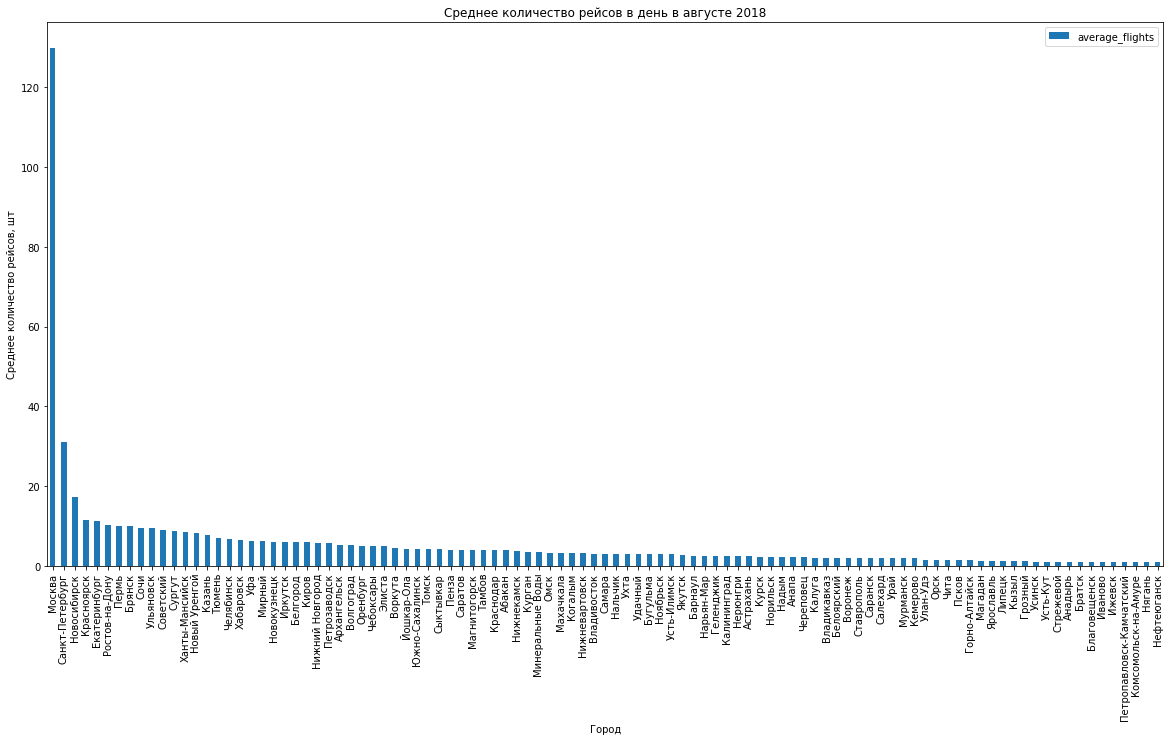


Медиана количества рейсов в день по всем городам:  average_flights    3.0
dtype: float64


In [50]:
dataset2.plot('city','average_flights',kind = 'bar',figsize=(20,10),title = 'Среднее количество рейсов в день в августе 2018')
plt.xlabel('Город')
plt.ylabel('Среднее количество рейсов, шт')
plt.show()

print()
print('Медиана количества рейсов в день по всем городам: ',dataset2.median())

Уверенный лидер по среднему количеству полетов в день в августе 2018 года - Москва (около 130 рейсов в день). На втором месте - Санкт-Петербург (около 31 рейста в день). На третьем месте Новосибирск (около 17 рейсов в день).
Всего в России в августе 2018 года в среднем 3 рейса прибывших, в каждый город. 

### График "ТОП-10 городов/количество рейсов"

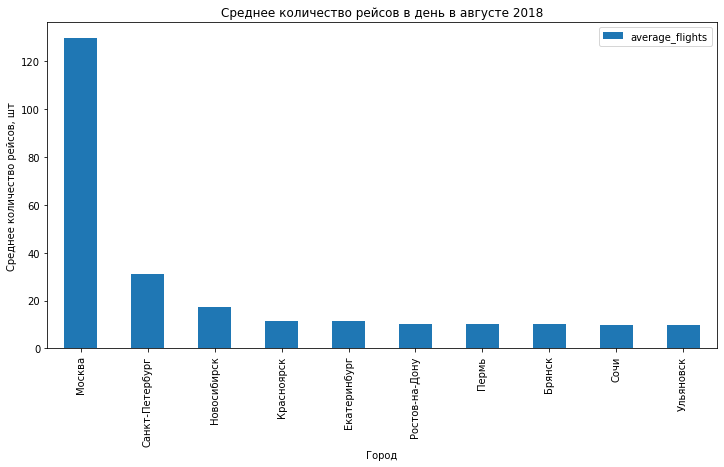

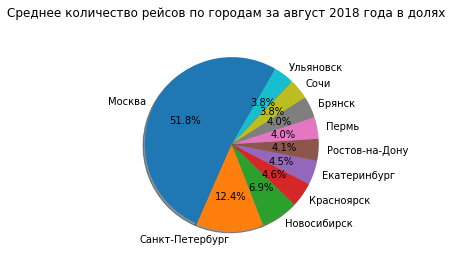

In [52]:
dataset3.plot('city','average_flights',kind = 'bar',figsize=(12,6),title = 'Среднее количество рейсов в день в августе 2018')
plt.xlabel('Город')
plt.ylabel('Среднее количество рейсов, шт')
plt.show()

plt.pie(labels = dataset3['city'], x = dataset3['average_flights'], autopct='%1.1f%%', shadow=True, startangle=60)
plt.suptitle('Среднее количество рейсов по городам за август 2018 года в долях')
plt.show()

Среди ТОП-10 городов по количеству средних полетов уверенный лидер также Москва, на нее приходится более половины (51,8%) рейсов. Второе и третье место занимают также Санкт-Петербург (12,4%) и Новосибирск (6,9%) соответсвенно. Остальные города занимают примерно равные доли (4,6% - 3,8%). 

## Итоговый вывод

в сентябре 2018 года 81% всех рейсов это частные и коммерческие рейсы на небольшие расстояния:
больше всего рейсов выполняется на небольших самолетах моделей "Bombardier CRJ-200", "Cessna 208 Caravan" и "Sukhoi Superjet-100". На них приходится около 81% всех рейсов. 

Меньше всего рейсов за сентябрь 2018 у модели Boeing 777-300. 

Уверенный лидер по среднему количеству полетов в день в августе 2018 года - Москва (около 130 рейсов в день). На втором месте - Санкт-Петербург (около 31 рейста в день). На третьем месте Новосибирск (около 17 рейсов в день).

Среди ТОП-10 на Москву приходится более половины рейсов (51,8%). Второе место занимает Санкт-Петербург (12,4%) и третье Новосибирск (6,9%). Остальные города занимают примерно равные доли (4,6% - 3,8%).  

Всего в России в августе 2018 года в среднем 3 рейса прибывших, в каждый город. 